<a href="https://colab.research.google.com/github/shivu2507/POS-Tagging-using-RNNs/blob/main/POS_Tagging_using_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**POS tagging** stands for **Parts of Speech Tagging**, where the given words are labelled accordingly with their respective parts of speech using  **nltk library** and since this is an **offline sequence processing**, **Bidirectional Recurrent Neural Networks(BRNN)** will be used to build the model.**bold text**

In [1]:
import nltk

In [2]:
nltk.download('brown')
nltk.download('treebank')
nltk.download('conll2000')
nltk.download('punkt')
nltk.download('universal_tagset')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

# Importing Libraries & Dataset

In [3]:
# Importing necessary libraries.

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import brown, treebank, conll2000

from gensim.models import KeyedVectors

from keras.models import Sequential, Model
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding, Dense, Input, TimeDistributed, LSTM, GRU, Bidirectional, SimpleRNN, RNN
from keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

%matplotlib inline

In [4]:
# Loading Corpora from NLTK library with POS tagging.
# tagged_sents returns a list((list(word, tag))) for each sentence.

brown_corpus = brown.tagged_sents(tagset ='universal')
conll_corpus = conll2000.tagged_sents(tagset = 'universal')
treebank_corpus = treebank.tagged_sents(tagset = 'universal')

In [5]:
# Combining the different corpus into single dataset.

tagged_sentences = brown_corpus + conll_corpus + treebank_corpus

## A Glimpse of the dataset

In [6]:
tagged_sentences[5]

[('It', 'PRON'),
 ('recommended', 'VERB'),
 ('that', 'ADP'),
 ('Fulton', 'NOUN'),
 ('legislators', 'NOUN'),
 ('act', 'VERB'),
 ('``', '.'),
 ('to', 'PRT'),
 ('have', 'VERB'),
 ('these', 'DET'),
 ('laws', 'NOUN'),
 ('studied', 'VERB'),
 ('and', 'CONJ'),
 ('revised', 'VERB'),
 ('to', 'ADP'),
 ('the', 'DET'),
 ('end', 'NOUN'),
 ('of', 'ADP'),
 ('modernizing', 'VERB'),
 ('and', 'CONJ'),
 ('improving', 'VERB'),
 ('them', 'PRON'),
 ("''", '.'),
 ('.', '.')]

### Observation

Single datapoint here refers to a sentence in the corpora and each datapoint is a list of tuples of words and tags in a sentence.

# Data Preprocessing

In this problem the input is a sentence and output should be the tags of each word in that  sentence. So from the dataset we need to seperate the words and tags of each sentences.<br>

So, X will be list of words in a sentence<br>
and Y will be list of corresponding POS tags.

In [7]:
X = [] # Stores list of sentences.
Y = [] # Stores list of corresponding POS Tags. 

for sentence in tagged_sentences: #for looping through each datapoint/sentence.

  X_sentence = [] #Stores words of single datapoint/sentence as a list.
  Y_sentence = [] #Stores POS Tags of corresponding sentence as a list.
  
  for word_tags in sentence: #for looping through each word and tag tuple in a single datapoint/sentence.
    X_sentence.append(word_tags[0]) #word_tags[0] refers to first element of the tuple i.e word.
    Y_sentence.append(word_tags[1]) #word_tags[1] refers to second element of the tuple i.e POS tags.

  X.append(X_sentence)
  Y.append(Y_sentence)


In [8]:
num_unique_words = len(set([word.lower() for sentence in X for word in sentence]))
num_unique_tags = len(set([word.lower() for sentence in Y for word in sentence]))

print("Total number of sentences : {}".format(len(X)))
print("Total number of words : {}".format(len([word for sentence in X for word in sentence])))
print("Total number of tags : {}".format(len([word for sentence in Y for word in sentence])))
print("Total number of unique words : {}".format(num_unique_words))
print("Total number of unique tags : {}".format(num_unique_tags))

Total number of sentences : 72202
Total number of words : 1520972
Total number of tags : 1520972
Total number of unique words : 59448
Total number of unique tags : 12


In [9]:
print("Sample Input : ", X[0])
print("Length of Sample Input : {}".format(len(X[0])))
print("Sample Output : ",Y[0])
print("Length of Sample Output : {}".format(len(Y[0])))

Sample Input :  ['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', 'Friday', 'an', 'investigation', 'of', "Atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.']
Length of Sample Input : 25
Sample Output :  ['DET', 'NOUN', 'NOUN', 'ADJ', 'NOUN', 'VERB', 'NOUN', 'DET', 'NOUN', 'ADP', 'NOUN', 'ADJ', 'NOUN', 'NOUN', 'VERB', '.', 'DET', 'NOUN', '.', 'ADP', 'DET', 'NOUN', 'VERB', 'NOUN', '.']
Length of Sample Output : 25


### Vectorizing X & Y

Since Neural Networks can only deal with numbers, there is a need to convert the text of the inputs and outputs into numbers.<br>

For converting text into numbers, Keras library has an inbuilt function named Tokenizer() which converts input text sequence into integer sequence.

In [10]:
# Creating an instance of Tokenizer() for X and Y.

X_tokenizer = Tokenizer()
Y_tokenizer = Tokenizer()

# Fitting the tokenizer on data.

X_tokenizer.fit_on_texts(X)
Y_tokenizer.fit_on_texts(Y)

# Tokenize the input sequence.

X_tokenized = X_tokenizer.texts_to_sequences(X)
Y_tokenized = Y_tokenizer.texts_to_sequences(Y)

In [11]:
# Comparing raw data with tokenized data.

print("Sample Raw Input : \n", X[0])
print("Sample Tokenized Input : \n",X_tokenized[0])

print("Sample Raw Output : \n", Y[0])
print("Sample Tokenized Output : \n",Y_tokenized[0])

Sample Raw Input : 
 ['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', 'Friday', 'an', 'investigation', 'of', "Atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.']
Sample Tokenized Input : 
 [1, 5731, 778, 2326, 1842, 39, 853, 34, 1944, 4, 16831, 379, 1343, 1523, 1116, 12, 67, 569, 14, 9, 89, 10208, 252, 205, 3]
Sample Raw Output : 
 ['DET', 'NOUN', 'NOUN', 'ADJ', 'NOUN', 'VERB', 'NOUN', 'DET', 'NOUN', 'ADP', 'NOUN', 'ADJ', 'NOUN', 'NOUN', 'VERB', '.', 'DET', 'NOUN', '.', 'ADP', 'DET', 'NOUN', 'VERB', 'NOUN', '.']
Sample Tokenized Output : 
 [5, 1, 1, 6, 1, 2, 1, 5, 1, 4, 1, 6, 1, 1, 2, 3, 5, 1, 3, 4, 5, 1, 2, 1, 3]


### Fixing the Input Sentence Length

Since we are dealing with sentences, not every sentence is of the same length and hence we need to fix a sentence length and based on this fixed length we need to either truncate longer sequences or pad the shorter sequences. 

In [12]:
# Checking the maximum length.

lengths = [len(sentence) for sentence in X_tokenized]
print("Maximum Length : {}".format(max(lengths)))

Maximum Length : 271


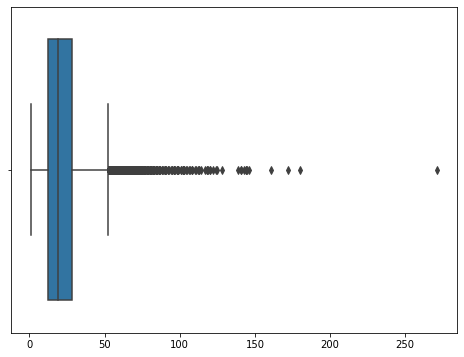

In [13]:
fig = plt.figure(figsize = [8,6])
ax = plt.gca()

ax = sns.boxplot(lengths)
plt.show()

Observation

*   There are a few outliers indicating that there are a few sentences which are exceptionally long and can be either removed or truncated.
*   Truncating is a good choice as sentences which are exceptionally long might be conjunction of two or more sentences.
  





### Padding

We will define a maximum length of 80 and all the sequences will be now of standard size 80 and for the sequences with shorter length it will be padded with zeros from the left side of the sequence and for longer sequences truncation will happen from right side of the sequence.

In [14]:
max_length = 80

X_padded = pad_sequences(X_tokenized, maxlen = max_length, padding = "pre", truncating = "post")
Y_padded = pad_sequences(Y_tokenized, maxlen = max_length, padding = "pre", truncating = "post")

In [15]:
# Comparing the tokenized sequence with padded sequence.

print("Sample Tokenized Input : \n\n", X_tokenized[0])
print("Sample Padded Input : \n\n", X_padded[0])

print("Sample Tokenized Output : \n\n", Y_tokenized[0])
print("Sample Padded Output : \n\n", Y_padded[0])

Sample Tokenized Input : 

 [1, 5731, 778, 2326, 1842, 39, 853, 34, 1944, 4, 16831, 379, 1343, 1523, 1116, 12, 67, 569, 14, 9, 89, 10208, 252, 205, 3]
Sample Padded Input : 

 [    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     1  5731   778  2326  1842
    39   853    34  1944     4 16831   379  1343  1523  1116    12    67
   569    14     9    89 10208   252   205     3]
Sample Tokenized Output : 

 [5, 1, 1, 6, 1, 2, 1, 5, 1, 4, 1, 6, 1, 1, 2, 3, 5, 1, 3, 4, 5, 1, 2, 1, 3]
Sample Padded Output : 

 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 1 1 6 1 2 1 5 1 4 1 6 1 1 2 3 5 1 3
 4 5 1 2 1 3]


In [16]:
X, Y = X_padded, Y_padded

### Creating Word Embeddings

Word embedding is a learned representation for texts where words with same meaning have similar representation.

word2vec is a pre-trained model that is used for word embedding and assigns each unique word a corresponding vector.

In [17]:
# Loading word2vec embedding model

EMBEDDING_FILE = '/root/input/GoogleNews-vectors-negative300.bin.gz'
!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary = True)

--2020-12-06 08:44:28--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.206.109
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.206.109|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [18]:
# Creating vectors for each unique words in the input.

EMBEDDING_SIZE = 300  #Number of dimensions of the vector space
VOCABULARY_SIZE = len(X_tokenizer.word_index) + 1 # Since we are padding the sequences we are adding 1.

# Creating an empty embedding matrix where each row represents single datapoint and columns represents the dimension of vector space.
embedding_weights = np.zeros((VOCABULARY_SIZE, EMBEDDING_SIZE))

# Creating a word to index dictionary mapping.
word2index = X_tokenizer.word_index

# Copying word2vec vectors to the words present in the input.
for word, index in word2index.items():
  try:
    embedding_weights[index, :] = word2vec[word]
  except KeyError:
    pass

In [19]:
# Checking the dimension of the embedding matrix.

print("Embedding Shape : {}".format(embedding_weights.shape))

Embedding Shape : (59449, 300)


In [20]:
# Looking at embedding of the word 'the'

embedding_weights[X_tokenizer.word_index['the']]

array([ 0.08007812,  0.10498047,  0.04980469,  0.0534668 , -0.06738281,
       -0.12060547,  0.03515625, -0.11865234,  0.04394531,  0.03015137,
       -0.05688477, -0.07617188,  0.01287842,  0.04980469, -0.08496094,
       -0.06347656,  0.00628662, -0.04321289,  0.02026367,  0.01330566,
       -0.01953125,  0.09277344, -0.171875  , -0.00131989,  0.06542969,
        0.05834961, -0.08251953,  0.0859375 , -0.00318909,  0.05859375,
       -0.03491211, -0.0123291 , -0.0480957 , -0.00302124,  0.05639648,
        0.01495361, -0.07226562, -0.05224609,  0.09667969,  0.04296875,
       -0.03540039, -0.07324219,  0.03271484, -0.06176758,  0.00787354,
        0.0035553 , -0.00878906,  0.0390625 ,  0.03833008,  0.04443359,
        0.06982422,  0.01263428, -0.00445557, -0.03320312, -0.04272461,
        0.09765625, -0.02160645, -0.0378418 ,  0.01190186, -0.01391602,
       -0.11328125,  0.09326172, -0.03930664, -0.11621094,  0.02331543,
       -0.01599121,  0.02636719,  0.10742188, -0.00466919,  0.09

### One Hot Encoding the Output

In [21]:
# Using keras to_categorical to one hot encode.
Y = to_categorical(Y)

# Checking the shape of Y
print("Number of Sentences : {}".format(Y.shape[0]))
print("Number of Sequences/Timesteps : {}".format(Y.shape[1]))
print("Number of Classes : {}".format(Y.shape[2]))

Number of Sentences : 72202
Number of Sequences/Timesteps : 80
Number of Classes : 13


## Splitting the Data

Split the data into training, validation and testing datasets.

In [22]:
# splitting entire dataset into train and test sets.

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 43)

# splitting the training data into training and validation sets.

X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size = 0.2, random_state = 43)

In [23]:
print('Training Data')
print("Shape of input sequences : {}".format(X_train.shape))
print('Shape of output sequences : {}'.format(Y_train.shape))
print("-"*50)

print('Validation Data')
print("Shape of input sequences : {}".format(X_valid.shape))
print('Shape of output sequences : {}'.format(Y_valid.shape))
print("-"*50)

print('Testing Data')
print("Shape of input sequences : {}".format(X_test.shape))
print('Shape of output sequences : {}'.format(Y_test.shape))

Training Data
Shape of input sequences : (46208, 80)
Shape of output sequences : (46208, 80, 13)
--------------------------------------------------
Validation Data
Shape of input sequences : (11553, 80)
Shape of output sequences : (11553, 80, 13)
--------------------------------------------------
Testing Data
Shape of input sequences : (14441, 80)
Shape of output sequences : (14441, 80, 13)


# Building Models

## Simple RNN Model 1

Building a plain RNN with randomly initialised embeddings and untrainable embedding weights with an architecure of 64 RNN cells.

In [24]:
num_classes = Y.shape[2]

# Architecture of Simple RNN Model 1

simple_rnn = Sequential()

# adding an embedding layer to randomly initialise the embedding vectors. 
simple_rnn.add(Embedding(input_dim = VOCABULARY_SIZE, output_dim = EMBEDDING_SIZE, input_length = max_length, trainable = False))

# adding an RNN layer with 64 RNN cells.
simple_rnn.add(SimpleRNN(64, return_sequences = True))

# adding time distributed layer - to predict at every timestep for each sequence.
simple_rnn.add(TimeDistributed(Dense(num_classes, activation = "softmax")))

### Compiling the model

In [25]:
simple_rnn.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])

# Checking the summary of the model.

simple_rnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 80, 300)           17834700  
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 80, 64)            23360     
_________________________________________________________________
time_distributed (TimeDistri (None, 80, 13)            845       
Total params: 17,858,905
Trainable params: 24,205
Non-trainable params: 17,834,700
_________________________________________________________________


### Fit Model

In [26]:
simple_rnn_training = simple_rnn.fit(X_train, Y_train, batch_size = 128, epochs = 10, validation_data = (X_valid, Y_valid))

Epoch 1/10
361/361 [==============================] - 12s 34ms/step - loss: 0.6236 - acc: 0.8199 - val_loss: 0.4346 - val_acc: 0.8714
Epoch 2/10
361/361 [==============================] - 12s 33ms/step - loss: 0.3602 - acc: 0.8901 - val_loss: 0.3074 - val_acc: 0.9062
Epoch 3/10
361/361 [==============================] - 12s 33ms/step - loss: 0.2740 - acc: 0.9151 - val_loss: 0.2495 - val_acc: 0.9220
Epoch 4/10
361/361 [==============================] - 12s 33ms/step - loss: 0.2324 - acc: 0.9262 - val_loss: 0.2184 - val_acc: 0.9297
Epoch 5/10
361/361 [==============================] - 12s 34ms/step - loss: 0.2074 - acc: 0.9332 - val_loss: 0.1982 - val_acc: 0.9361
Epoch 6/10
361/361 [==============================] - 12s 33ms/step - loss: 0.1907 - acc: 0.9382 - val_loss: 0.1845 - val_acc: 0.9399
Epoch 7/10
361/361 [==============================] - 12s 33ms/step - loss: 0.1791 - acc: 0.9411 - val_loss: 0.1750 - val_acc: 0.9424
Epoch 8/10
361/361 [==============================] - 12s 33ms

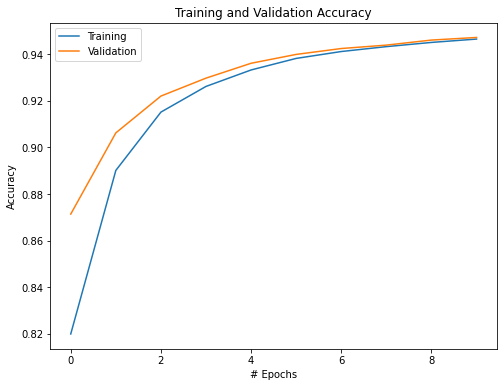

In [27]:
plt.figure(figsize = [8,6])
plt.plot(simple_rnn_training.history['acc'])
plt.plot(simple_rnn_training.history['val_acc'])
plt.title("Training and Validation Accuracy")
plt.xlabel("# Epochs")
plt.ylabel("Accuracy")
plt.legend(['Training', "Validation"], loc = 'best')
plt.show()

## Simple RNN Model 2
Simple RNN Model with randomly initialised embedding weights and trainable embedding weights.

In [28]:
# Architecture of Simple RNN Model 2

simple_rnn_2 = Sequential()

# adding an embedding layer to randomly initialise the embedding vectors. 
simple_rnn_2.add(Embedding(input_dim = VOCABULARY_SIZE, output_dim = EMBEDDING_SIZE, input_length = max_length, trainable = True))

# adding an RNN layer with 64 RNN cells.
simple_rnn_2.add(SimpleRNN(64, return_sequences = True))

# adding time distributed layer - to predict at every timestep for each sequence.
simple_rnn_2.add(TimeDistributed(Dense(num_classes, activation = "softmax")))

### Compiling the model

In [29]:
simple_rnn_2.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])

# Checking the summary.

simple_rnn_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 80, 300)           17834700  
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 80, 64)            23360     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 80, 13)            845       
Total params: 17,858,905
Trainable params: 17,858,905
Non-trainable params: 0
_________________________________________________________________


### Fit Model

In [30]:
simple_rnn_2_training = simple_rnn_2.fit(X_train, Y_train, batch_size = 128, epochs = 10, validation_data=(X_valid, Y_valid))

Epoch 1/10
361/361 [==============================] - 72s 201ms/step - loss: 0.2655 - acc: 0.9386 - val_loss: 0.0558 - val_acc: 0.9837
Epoch 2/10
361/361 [==============================] - 72s 200ms/step - loss: 0.0392 - acc: 0.9876 - val_loss: 0.0385 - val_acc: 0.9869
Epoch 3/10
361/361 [==============================] - 72s 200ms/step - loss: 0.0266 - acc: 0.9908 - val_loss: 0.0354 - val_acc: 0.9876
Epoch 4/10
361/361 [==============================] - 72s 200ms/step - loss: 0.0218 - acc: 0.9923 - val_loss: 0.0346 - val_acc: 0.9878
Epoch 5/10
361/361 [==============================] - 72s 201ms/step - loss: 0.0186 - acc: 0.9934 - val_loss: 0.0354 - val_acc: 0.9877
Epoch 6/10
361/361 [==============================] - 73s 202ms/step - loss: 0.0161 - acc: 0.9944 - val_loss: 0.0368 - val_acc: 0.9875
Epoch 7/10
361/361 [==============================] - 72s 200ms/step - loss: 0.0137 - acc: 0.9954 - val_loss: 0.0387 - val_acc: 0.9873
Epoch 8/10
361/361 [==============================] - 7

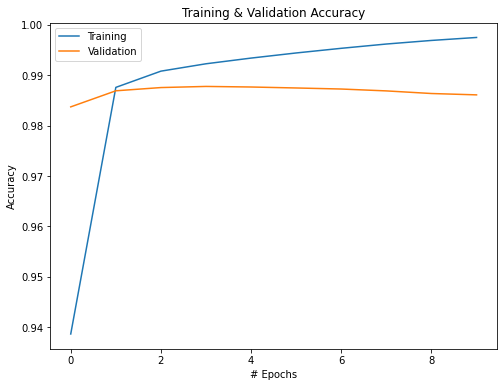

In [31]:
plt.figure(figsize = [8,6])
plt.plot(simple_rnn_2_training.history['acc'])
plt.plot(simple_rnn_2_training.history['val_acc'])
plt.title("Training & Validation Accuracy")
plt.xlabel('# Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'], loc = 'best')
plt.show()

## Simple RNN Model 3

Simple RNN model with pre-trained word2vec trainable embedding weights.

In [32]:
# Architecture of Simple RNN Model 3

simple_rnn_3 = Sequential()

# adding an embedding layer with pre-trained word2vec embedding vectors. 
simple_rnn_3.add(Embedding(input_dim = VOCABULARY_SIZE, output_dim = EMBEDDING_SIZE, input_length = max_length, weights = [embedding_weights],
                           trainable = True))

# adding an RNN layer with 64 RNN cells.
simple_rnn_3.add(SimpleRNN(64, return_sequences = True))

# adding time distributed layer - to predict at every timestep for each sequence.
simple_rnn_3.add(TimeDistributed(Dense(num_classes, activation = "softmax")))

### Compiling the model

In [33]:
simple_rnn_3.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics =['acc'])

# Checking the summary.

simple_rnn_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 80, 300)           17834700  
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 80, 64)            23360     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 80, 13)            845       
Total params: 17,858,905
Trainable params: 17,858,905
Non-trainable params: 0
_________________________________________________________________


### Fit Model

In [34]:
simple_rnn_3_training = simple_rnn_3.fit(X_train, Y_train, batch_size = 128, epochs = 10, validation_data = (X_valid, Y_valid))

Epoch 1/10
361/361 [==============================] - 73s 204ms/step - loss: 0.2269 - acc: 0.9532 - val_loss: 0.0446 - val_acc: 0.9861
Epoch 2/10
361/361 [==============================] - 73s 202ms/step - loss: 0.0337 - acc: 0.9887 - val_loss: 0.0342 - val_acc: 0.9882
Epoch 3/10
361/361 [==============================] - 73s 201ms/step - loss: 0.0250 - acc: 0.9911 - val_loss: 0.0320 - val_acc: 0.9885
Epoch 4/10
361/361 [==============================] - 73s 201ms/step - loss: 0.0213 - acc: 0.9923 - val_loss: 0.0313 - val_acc: 0.9888
Epoch 5/10
361/361 [==============================] - 73s 202ms/step - loss: 0.0187 - acc: 0.9932 - val_loss: 0.0316 - val_acc: 0.9888
Epoch 6/10
361/361 [==============================] - 73s 201ms/step - loss: 0.0165 - acc: 0.9941 - val_loss: 0.0324 - val_acc: 0.9887
Epoch 7/10
361/361 [==============================] - 73s 201ms/step - loss: 0.0144 - acc: 0.9950 - val_loss: 0.0337 - val_acc: 0.9884
Epoch 8/10
361/361 [==============================] - 7

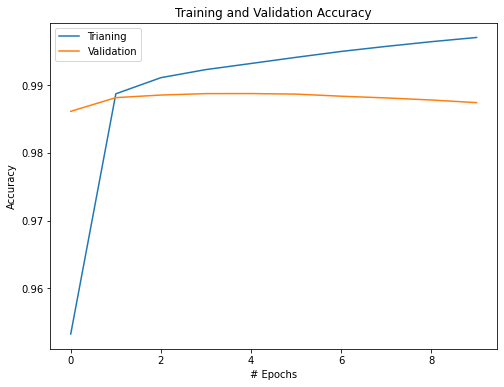

In [35]:
plt.figure(figsize = [8,6])
plt.plot(simple_rnn_3_training.history['acc'])
plt.plot(simple_rnn_3_training.history['val_acc'])
plt.title('Training and Validation Accuracy')
plt.xlabel('# Epochs')
plt.ylabel('Accuracy')
plt.legend(['Trianing','Validation'], loc = 'best')
plt.show()

## LSTM Model

Replacing the RNN cells of Simple RNN model 3 with LSTM cells to build LSTM model with pre-trained trainable embedding weights

In [36]:
# Architecture of LSTM Model

lstm_model = Sequential()

# adding an embedding layer with pre-trained word2vec embedding vectors. 
lstm_model.add(Embedding(input_dim = VOCABULARY_SIZE, output_dim = EMBEDDING_SIZE, input_length = max_length, weights = [embedding_weights],
                           trainable = True))

# adding an LSTM layer with 64 LSTM cells.
lstm_model.add(LSTM(64, return_sequences = True))

# adding time distributed layer - to predict at every timestep for each sequence.
lstm_model.add(TimeDistributed(Dense(num_classes, activation = "softmax")))

### Compiling the model

In [37]:
lstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])

# Checking the summary.

lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 80, 300)           17834700  
_________________________________________________________________
lstm (LSTM)                  (None, 80, 64)            93440     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 80, 13)            845       
Total params: 17,928,985
Trainable params: 17,928,985
Non-trainable params: 0
_________________________________________________________________


### Fit Model

In [38]:
lstm_model_training = lstm_model.fit(X_train, Y_train, batch_size = 128, epochs = 10, validation_data = (X_valid, Y_valid))

Epoch 1/10
361/361 [==============================] - 63s 175ms/step - loss: 0.3565 - acc: 0.9203 - val_loss: 0.0603 - val_acc: 0.9840
Epoch 2/10
361/361 [==============================] - 63s 175ms/step - loss: 0.0426 - acc: 0.9869 - val_loss: 0.0376 - val_acc: 0.9873
Epoch 3/10
361/361 [==============================] - 63s 176ms/step - loss: 0.0294 - acc: 0.9897 - val_loss: 0.0329 - val_acc: 0.9883
Epoch 4/10
361/361 [==============================] - 64s 176ms/step - loss: 0.0245 - acc: 0.9911 - val_loss: 0.0310 - val_acc: 0.9889
Epoch 5/10
361/361 [==============================] - 64s 178ms/step - loss: 0.0217 - acc: 0.9921 - val_loss: 0.0303 - val_acc: 0.9891
Epoch 6/10
361/361 [==============================] - 64s 178ms/step - loss: 0.0195 - acc: 0.9929 - val_loss: 0.0299 - val_acc: 0.9894
Epoch 7/10
361/361 [==============================] - 64s 178ms/step - loss: 0.0174 - acc: 0.9937 - val_loss: 0.0301 - val_acc: 0.9895
Epoch 8/10
361/361 [==============================] - 6

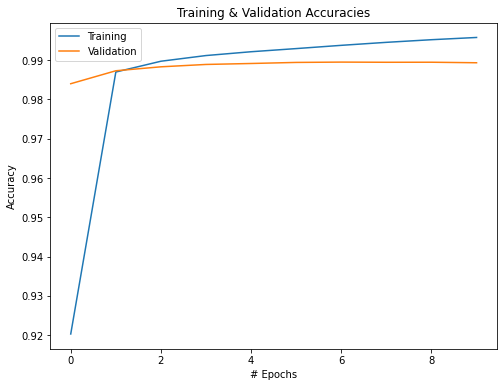

In [39]:
plt.figure(figsize = [8,6])
plt.plot(lstm_model_training.history['acc'])
plt.plot(lstm_model_training.history['val_acc'])
plt.title("Training & Validation Accuracies")
plt.xlabel('# Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'], loc = 'best')
plt.show()

## GRU Model

Replacing the LSTM cells of LSTM Model with GRU cells to build GRU model with pre-trained trainable embedding weights

In [40]:
# Architecture of GRU Model

gru_model = Sequential()

# adding an embedding layer with pre-trained embedding vectors. 
gru_model.add(Embedding(input_dim = VOCABULARY_SIZE, output_dim = EMBEDDING_SIZE, input_length = max_length, weights = [embedding_weights],
                           trainable = True))

# adding an GRU layer with 64 GRU cells.
gru_model.add(GRU(64, return_sequences = True))

# adding time distributed layer - to predict at every timestep for each sequence.
gru_model.add(TimeDistributed(Dense(num_classes, activation = "softmax")))

### Compiling the model

In [41]:
gru_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])

# Checking the summary.

gru_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 80, 300)           17834700  
_________________________________________________________________
gru (GRU)                    (None, 80, 64)            70272     
_________________________________________________________________
time_distributed_4 (TimeDist (None, 80, 13)            845       
Total params: 17,905,817
Trainable params: 17,905,817
Non-trainable params: 0
_________________________________________________________________


### Fit Model

In [42]:
gru_model_training = gru_model.fit(X_train, Y_train, batch_size = 128, epochs = 10, validation_data = (X_valid, Y_valid))

Epoch 1/10
361/361 [==============================] - 65s 179ms/step - loss: 0.2561 - acc: 0.9483 - val_loss: 0.0432 - val_acc: 0.9857
Epoch 2/10
361/361 [==============================] - 65s 179ms/step - loss: 0.0334 - acc: 0.9883 - val_loss: 0.0333 - val_acc: 0.9880
Epoch 3/10
361/361 [==============================] - 65s 179ms/step - loss: 0.0255 - acc: 0.9906 - val_loss: 0.0310 - val_acc: 0.9887
Epoch 4/10
361/361 [==============================] - 64s 179ms/step - loss: 0.0222 - acc: 0.9918 - val_loss: 0.0301 - val_acc: 0.9890
Epoch 5/10
361/361 [==============================] - 63s 176ms/step - loss: 0.0201 - acc: 0.9925 - val_loss: 0.0299 - val_acc: 0.9892
Epoch 6/10
361/361 [==============================] - 64s 176ms/step - loss: 0.0184 - acc: 0.9931 - val_loss: 0.0300 - val_acc: 0.9891
Epoch 7/10
361/361 [==============================] - 65s 179ms/step - loss: 0.0170 - acc: 0.9937 - val_loss: 0.0305 - val_acc: 0.9891
Epoch 8/10
361/361 [==============================] - 6

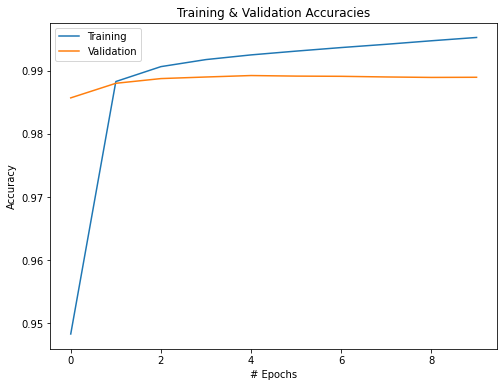

In [43]:
plt.figure(figsize = [8,6])
plt.plot(gru_model_training.history['acc'])
plt.plot(gru_model_training.history['val_acc'])
plt.title("Training & Validation Accuracies")
plt.xlabel('# Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'], loc = 'best')
plt.show()

## Bidirectional LSTM Model

Replacing LSTM layer with bidirectional LSTM layer


In [47]:
# Architecture of bidirectional LSMT model

bidirectional_LSTM = Sequential()

# adding an embedding layer with pre-trained embedding word2vec embedding vectors

bidirectional_LSTM.add(Embedding(input_dim = VOCABULARY_SIZE, output_dim = EMBEDDING_SIZE, input_length = max_length, weights =[embedding_weights],
                                 trainable = True))

# adding bidirectional LSTM layer with 64 cells.

bidirectional_LSTM.add(Bidirectional(LSTM(64, return_sequences = True)))

# adding TimeDistributed layer for output at each timestep.

bidirectional_LSTM.add(TimeDistributed(Dense(num_classes, activation = "softmax")))

### Compiling the model

In [48]:
bidirectional_LSTM.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])

# Checking the summary

bidirectional_LSTM.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 80, 300)           17834700  
_________________________________________________________________
bidirectional (Bidirectional (None, 80, 128)           186880    
_________________________________________________________________
time_distributed_5 (TimeDist (None, 80, 13)            1677      
Total params: 18,023,257
Trainable params: 18,023,257
Non-trainable params: 0
_________________________________________________________________


### Fit Model

In [49]:
bidirectional_LSTM_training = bidirectional_LSTM.fit(X_train, Y_train, batch_size = 128, epochs = 10, validation_data = (X_valid, Y_valid))

Epoch 1/10
361/361 [==============================] - 67s 185ms/step - loss: 0.2924 - acc: 0.9276 - val_loss: 0.0417 - val_acc: 0.9871
Epoch 2/10
361/361 [==============================] - 67s 185ms/step - loss: 0.0299 - acc: 0.9904 - val_loss: 0.0280 - val_acc: 0.9905
Epoch 3/10
361/361 [==============================] - 66s 184ms/step - loss: 0.0203 - acc: 0.9932 - val_loss: 0.0247 - val_acc: 0.9916
Epoch 4/10
361/361 [==============================] - 66s 184ms/step - loss: 0.0161 - acc: 0.9946 - val_loss: 0.0235 - val_acc: 0.9920
Epoch 5/10
361/361 [==============================] - 67s 184ms/step - loss: 0.0132 - acc: 0.9956 - val_loss: 0.0232 - val_acc: 0.9922
Epoch 6/10
361/361 [==============================] - 67s 185ms/step - loss: 0.0106 - acc: 0.9965 - val_loss: 0.0232 - val_acc: 0.9924
Epoch 7/10
361/361 [==============================] - 67s 185ms/step - loss: 0.0084 - acc: 0.9973 - val_loss: 0.0240 - val_acc: 0.9924
Epoch 8/10
361/361 [==============================] - 6

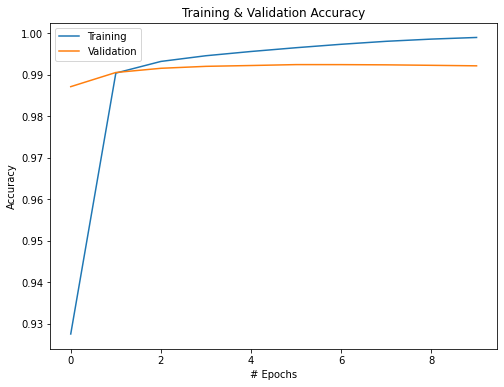

In [51]:
plt.figure(figsize = [8,6])
plt.plot(bidirectional_LSTM_training.history['acc'])
plt.plot(bidirectional_LSTM_training.history['val_acc'])
plt.title("Training & Validation Accuracy")
plt.xlabel('# Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training','Validation'], loc = 'best')
plt.show()

# Model Evaluation

In [64]:
models = ['RNN with untrainable embedding weights', 'RNN with trainable embedding weights','RNN with pre-trained trainable embedding weights',
          'LSTM with pre-trained trainable embedding weights','GRU with pre-trained trainable embedding weights',
          'Bidirectional LSTM with pre-trained trainable embedding weights']
loss_1, acc_1 = simple_rnn.evaluate(X_test, Y_test)
loss_2, acc_2 = simple_rnn_2.evaluate(X_test, Y_test)
loss_3, acc_3 = simple_rnn_3.evaluate(X_test, Y_test)
loss_4, acc_4 = lstm_model.evaluate(X_test, Y_test)
loss_5, acc_5 = gru_model.evaluate(X_test, Y_test)
loss_6, acc_6 = bidirectional_LSTM.evaluate(X_test, Y_test)

losses = [loss_1, loss_2, loss_3, loss_4, loss_5, loss_6]
accuracies = [acc_1, acc_2, acc_3, acc_4, acc_5, acc_6]

452/452 [==============================] - 2s 5ms/step - loss: 0.0275 - acc: 0.9923


In [65]:
for i in range(len(models)):
  print("Model Name : \n{0}\n\nModel Loss : {1} Model Accuracy {2}\n".format(models[i], losses[i], accuracies[i]))

Model Name : 
RNN with untrainable embedding weights

Model Loss : 0.1552082598209381 Model Accuracy 0.9481614828109741

Model Name : 
RNN with trainable embedding weights

Model Loss : 0.04573533684015274 Model Accuracy 0.9865833520889282

Model Name : 
RNN with pre-trained trainable embedding weights

Model Loss : 0.03937404975295067 Model Accuracy 0.9879457950592041

Model Name : 
LSTM with pre-trained trainable embedding weights

Model Loss : 0.032016556710004807 Model Accuracy 0.9896059632301331

Model Name : 
GRU with pre-trained trainable embedding weights

Model Loss : 0.032375577837228775 Model Accuracy 0.9891567230224609

Model Name : 
Bidirectional LSTM with pre-trained trainable embedding weights

Model Loss : 0.027533454820513725 Model Accuracy 0.9922797679901123



### Observation
* It can be seen that baseline model was performing very well with a testing accuracy of 94.8% and just by using trainable embedding weights the model performs exceptionally well.



